In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk import unit
from sys import stdout
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.stats import norm

In [2]:
f = open('tip3p-1.pdb', 'w')
f.write("""REMARK   1 CREATED WITH OPENMM 7.1.1, 2018-04-06
CRYST1   24.668   24.668   24.668  90.00  90.00  90.00 P 1           1 
HETATM    1  O   HOH A   1      20.854   7.945   2.695  1.00  0.00           O  
HETATM    2  H1  HOH A   1      20.168   7.772   3.339  1.00  0.00           H  
HETATM    3  H2  HOH A   1      21.142   8.838   2.885  1.00  0.00           H  
END""")
f.close()

In [3]:
pdb = PDBFile('tip3p-1.pdb')
omm_forcefield= ForceField('amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(omm_forcefield, ionicStrength=0.15*unit.molar, padding=2*unit.nanometer)
PDBFile.writeFile(modeller.topology, modeller.positions, file=open('solvated.pdb', 'w'))

sod = [i.index for i in modeller.topology.atoms() if i.residue.name=='NA'][0]
cla = [i.index for i in modeller.topology.atoms() if i.residue.name=='CL'][0]


# Create a System object
It has an attached collective variable measuring bond distance between the sod and cla atoms.

In [4]:
def makeSystem():
    system = omm_forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
         nonbondedCutoff=0.9*unit.nanometer, constraints=HBonds)

    kappa = 100*unit.kilocalories_per_mole**2
    nrg_expr = "0.5 * kappa * (delta_cv) ^ 2;"
    nrg_expr += "delta_cv = abs(r - extended_particle_position)"
    ion_force = CustomBondForce(nrg_expr)
    ion_force.addGlobalParameter('kappa', kappa)
    ion_force.addGlobalParameter('extended_particle_position', 1*unit.nanometer)
    ion_force.addEnergyParameterDerivative('extended_particle_position')
    ion_force.addBond(sod, cla, [])
    ion_force.setUsesPeriodicBoundaryConditions(True)
    ion_force.setForceGroup(16)
    system.addForce(ion_force)
    
    return system

# Define an integrator 
This is just a langevin integrator - but it has an extra GlobalVariable, which just stores the value of the derivative wrt the custom cv force. That allows us to get this value (after performing a normal langevin integration step on the real coordinates of the real particles), and then use this to calculate new values for the global parameter `extended_particle_position`

In [5]:
class CustomLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt):
        CustomIntegrator.__init__(self, dt)
            #normal langevin:  
        self.addGlobalVariable("extended_particle_deriv", 0)
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
            #normal langevin:                                                                  
        self.addUpdateContextState();
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original:                                                                                      
        self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        
        #last step:
        self.addComputeGlobal("extended_particle_deriv", "deriv(energy16, extended_particle_position)")


# Make a simulation object:

In [6]:
def makeSimulation(modeller, system):
    integrator = CustomLangevinIntegrator(298*unit.kelvin, 1/unit.picosecond, 2*unit.femtosecond)
    platform = Platform.getPlatformByName('OpenCL')
    prop = {'OpenCLPrecision':'single'}

    simulation = Simulation(modeller.topology, system, integrator, platform, prop)
    simulation.context.setPositions(modeller.positions)

    #calculate current distance of ions:
    state = simulation.context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True)
    box = state.getPeriodicBoxVectors(asNumpy=True).sum(0)/unit.nanometer

    diff = np.abs(positions[sod]-positions[cla])
    #where the per-coordinate distance is greater than half a PBC, get the shorter distance:
    diff = np.linalg.norm(np.where(diff>box/2, box-diff, diff))
    start_distance = np.linalg.norm(diff)
    #set the extended particle position to begin at this point:
    simulation.context.setParameter('extended_particle_position', start_distance)

    
    simulation.minimizeEnergy()
    PDBFile.writeFile(modeller.topology, simulation.context.getState(getPositions=True).getPositions(), 
                             open('wat.pdb', 'w'))
    
    return simulation, integrator

# Wrap a bunch of setup into the 'step' functions

In [7]:
def simulate_normally(nsteps, simulation):
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True,
                                              potentialEnergy=True, density=True, speed=True))
    simulation.step(nsteps)

def simulate_tamd(nsteps, simulation, integrator):
    mass = 500 #dalton
    temp = 298 #should be higher to get higher noise from heat bath to overcome obstacles?
    kT = 0.00831451*temp

    curr_pos = simulation.context.getParameter('extended_particle_position')
    print(curr_pos)
    #get the maximum of the bond distance: (i.e. the minimum PBC)
    state = simulation.context.getState()
    maxdist = state.getPeriodicBoxVectors(asNumpy=True).sum(0)/unit.nanometer

    extended_derivs = list()
    extended_pos = list()
    
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True,
                                              potentialEnergy=True, density=True, speed=True))

    for i in range(nsteps):
        #integrate real coordinates based on current extended particle position:
        simulation.step(1)
        #get the derivative of the custom bond force wrt the extended particle position:
        curr_deriv = integrator.getGlobalVariableByName('extended_particle_deriv')
        #force is negative of derivative of PE:
        f = -curr_deriv
    
        #perform diffusive regime (i.e. brownian motion) on extended particle:
        noise = (kT**0.5 * norm.rvs(0,0.1)) / mass**0.5
        v = f / mass * noise
        curr_pos += v
        curr_pos = np.clip(curr_pos, 0.2, maxdist[0])
    
        #set the new position:
        simulation.context.setParameter('extended_particle_position', curr_pos)
    
        #if i%100==0:
        extended_derivs.append(curr_deriv)
        extended_pos.append(curr_pos)
    
    return extended_derivs, extended_pos

# Run normal MD hold CV constant:

In [8]:
system = makeSystem()
simulation, _ = makeSimulation(modeller, system)

simulate_normally(10000, simulation)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Density (g/mL)","Speed (ns/day)"
1000,-118768.2282451425,258.3690523637678,0.971247066919215,0
2000,-115607.0719951425,284.6791770506389,0.971247066919215,265
3000,-114146.4469951425,289.5178653804698,0.971247066919215,269
4000,-114516.7282451425,302.2857531112923,0.971247066919215,271
5000,-114094.7282451425,301.262094798483,0.971247066919215,271
6000,-113951.3844951425,301.6475610945566,0.971247066919215,272
7000,-113868.1969951425,300.32327411320045,0.971247066919215,272
8000,-114264.1032451425,303.2581444067238,0.971247066919215,272
9000,-113968.0094951425,298.99362564608987,0.971247066919215,272
10000,-113976.7594951425,297.4607313137767,0.971247066919215,273


# Run TAMD with brownian motion on CV:

In [9]:
system = makeSystem()
simulation, integrator = makeSimulation(modeller, system)

ext_derivs, ext_pos = simulate_tamd(10000, simulation, integrator)

1.1315780097865096
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Density (g/mL)","Speed (ns/day)"
1000,-118667.5719951425,255.01658190203452,0.971247066919215,0
2000,-115713.1344951425,295.26998618362825,0.971247066919215,243
3000,-114870.3532451425,294.567596507401,0.971247066919215,243
4000,-114482.6969951425,300.1342905009527,0.971247066919215,243
5000,-114439.1969951425,294.08138333848996,0.971247066919215,243
6000,-114077.3532451425,305.03973458478544,0.971247066919215,243
7000,-113953.1032451425,301.6050196324263,0.971247066919215,243
8000,-113936.0094951425,293.6671822821636,0.971247066919215,243
9000,-114258.3844951425,303.364147638144,0.971247066919215,243
10000,-114597.3219951425,300.20045053431517,0.971247066919215,243


Text(0.5, 1.0, 'Extended positions (ion distance)')

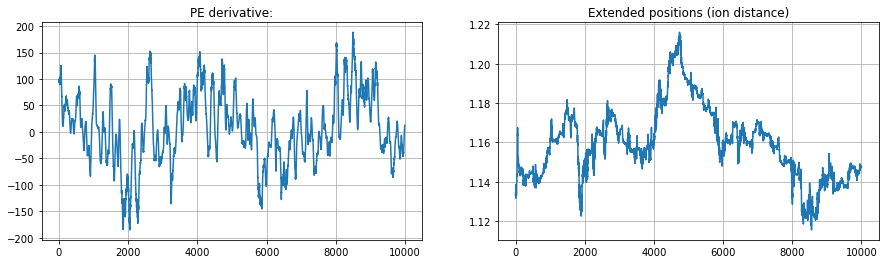

In [12]:
fig, ax  = plt.subplots(1,2)
fig.set_figwidth(15)
ax[0].plot(ext_derivs)
ax[1].plot(ext_pos)
for a in ax:
    a.grid()
    
ax[0].set_title('PE derivative:')
ax[1].set_title('Extended positions (ion distance)')

In [14]:
curr_deriv = 10*unit.kilojoules_per_mole
kT = unit.MOLAR_GAS_CONSTANT_R * 298*unit.kelvin
mass = 500*unit.dalton
f = -curr_deriv * unit.kilojoules_per_mole

noise = (kT**0.5 * norm.rvs(0,1)) / mass**0.5
noise

Quantity(value=1.15561369467071, unit=joule**0.5/(mole**0.5*dalton**0.5))

In [15]:
f / mass * noise

Quantity(value=-0.0007308742740883658, unit=kilojoule**2.5/(mole**2.5*dalton**1.5))